# 2 Coalition and Invariance for Shapley Values

In [1]:
import warnings
warnings.filterwarnings('ignore')

from acv_explainers import ACVTree
import shap

import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
import random 
import numpy as np
import pandas as pd
import seaborn as sns

random.seed(2021)
np.random.seed(2021)

In [2]:
from experiments.exp_linear_gmm import *
from experiments.exp_linear_gmm_ohe import *

In [3]:
# Fixed the seed and plot env
random.seed(2019)
np.random.seed(2019)


plt.style.use(['ggplot'])

###  Data init

In [4]:
## Generate new random covariance matrix 

# d = 3
# # p = 0.
# # cov = {key: np.array([[1, p, p, p], [p, 1, p, p], [p, p, 1, p], [p, p, p, 1]]) for key in ['a', 'b', 'c']}
# cov = {}
# for key in ['a', 'b', 'c']:
#     b = np.random.randn(d, d)
#     cov[key] = np.dot(b, b.T)
# cov

In [5]:
d = 3

cov = {'a': np.array([[ 0.41871254, -0.79006136,  0.46956991],
        [-0.79006136,  1.90865098, -0.82571655],
        [ 0.46956991, -0.82571655,  0.95835472]]),
 'b': np.array([[ 0.55326081,  0.11811951, -0.70677924],
        [ 0.11811951,  2.73312979, -2.94400196],
        [-0.70677924, -2.94400196,  4.22105088]]),
 'c': np.array([[ 9.2859966 ,  1.12872646,  2.4224434 ],
        [ 1.12872646,  0.92891237, -0.14373393],
        [ 2.4224434 , -0.14373393,  1.81601676]])}

In [6]:
n = 40000
# mean_a = np.random.randn(d)
# mean_b = np.random.randn(d)
# mean_c = np.random.randn(d)

mean_a = np.zeros(d)
mean_b = np.zeros(d)
mean_c = np.zeros(d)


exp = ExperimentsLinearGMM(mean={'a': mean_a, 'b': mean_b, 'c': mean_c}, cov=cov,
                           coefs={'a': [1, 3, 5], 'b': [-5, -10, -8], 'c': [6, 1, 0]},
                           pi={'a': 0.3, 'b': 0.3, 'c': 0.4}, n=n, C=[[3, 4]],
                           cat_index=[3, 4])

exp_ohe = ExperimentsLinearGMMOhe(mean={'a': mean_a, 'b': mean_b, 'c': mean_c}, cov=cov,
                           coefs={'a': [1, 3, 5], 'b': [-5, -10, -8], 'c': [6, 1, 0]},
                           pi={'a': 0.3, 'b': 0.3, 'c': 0.4}, n=n, C=[[3, 4, 5]],
                           cat_index=[3, 4, 5])


### SV computation

In [7]:
nb = 100
x_0 = np.linspace(-4, 2, nb)
sample = []
sample_shap = []
sample_shap_c = []
sample_shap_ohe = []
for i, x in enumerate(tqdm(x_0)):

#     a = sampleMVN(1, exp.mean['a'], exp.cov['a'], [1, 2], [0], x)
#     sample.append(np.concatenate(([x], a[0], [1, 0, 0])))   

    sample.append(exp_ohe.data_test[i])    
    exp.C = [[]]
    sample_shap.append(exp.linear_gmm_shap(sample[-1][:-1], False))
    
    exp_ohe.C = [[]] 
    sample_shap_ohe.append(exp_ohe.linear_gmm_shap(sample[-1], False))
    
    exp.C = [[3, 4]]
    sample_shap_c.append(exp.linear_gmm_shap(sample[-1][:-1], False))

100%|██████████| 100/100 [06:26<00:00,  3.86s/it]


## 2.3 Coalition or Sum: numerical comparisons (left figure)

In [8]:
s_shap = np.round(np.array(sample_shap), 3)
s_shap_ohe = np.round(np.array(sample_shap_ohe), 3)
s_shap_c = np.round(np.array(sample_shap_c), 3)


s_shap_sum = np.round(s_shap.copy(), 3)
sum_v = s_shap_sum[:, 3] + s_shap_sum[:, 4]
s_shap_sum[:, 3] = sum_v
s_shap_sum[:, 4] = sum_v
s_shap_sum = np.round(s_shap_sum, 3)


s_shap_ohe_sum = np.round(s_shap_ohe.copy(), 3)
sum_v = s_shap_ohe_sum[:, 3] + s_shap_ohe_sum[:, 4] + s_shap_ohe_sum[:, 5] 
s_shap_ohe_sum[:, 3] = sum_v
s_shap_ohe_sum[:, 4] = sum_v
s_shap_ohe_sum[:, 5] = sum_v
s_shap_ohe_sum = np.round(s_shap_ohe_sum, 3)

variables_name = ['X{}'.format(i) for i in range(len(s_shap_c[0])-2)] + ['Y']

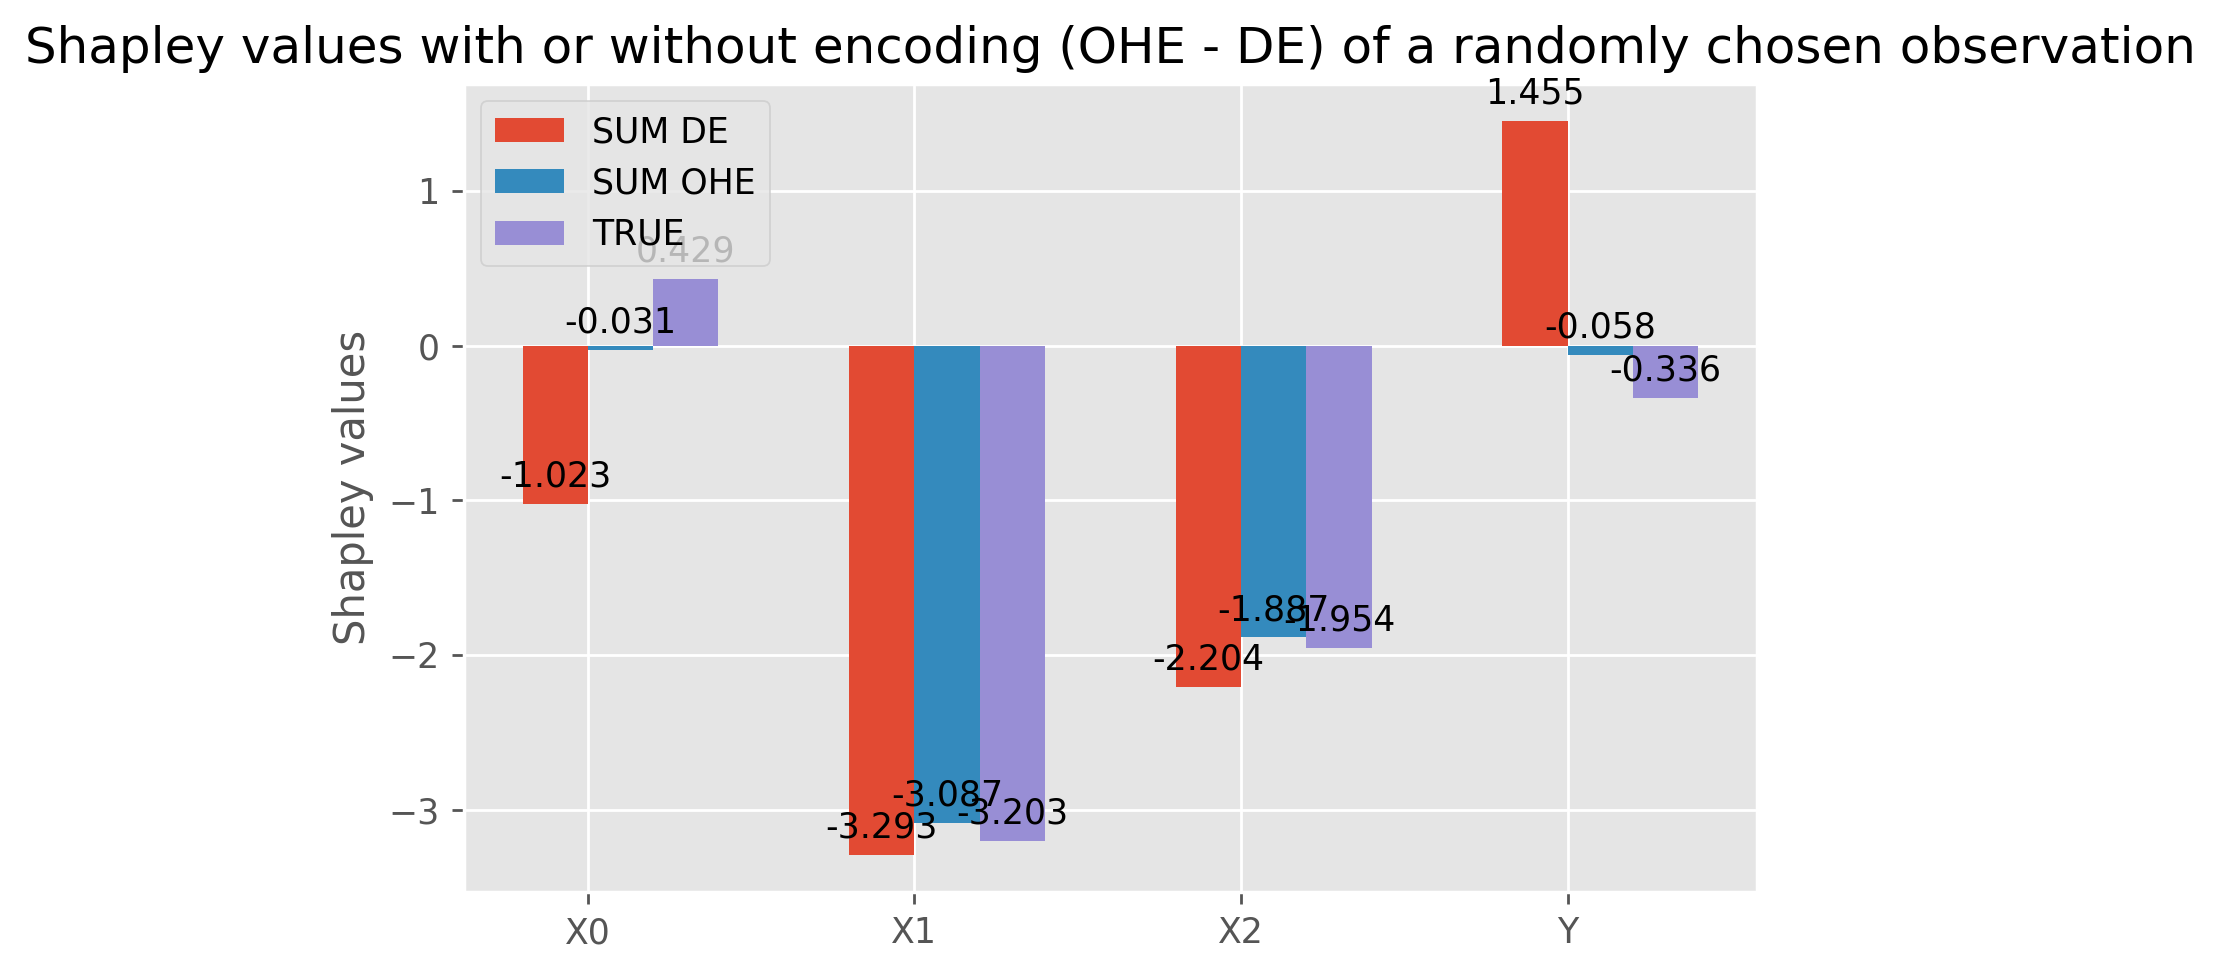

In [9]:
# idx = np.random.randint(0, nb)
idx = 4
bar_plot(s_shap_sum[idx][:-1], s_shap_ohe_sum[idx][:-2], s_shap_c[idx][:-1], labels=['SUM DE', 'SUM OHE', 'TRUE'],
         variables_name=variables_name,
         title='Shapley values with or without encoding (OHE - DE) of a randomly chosen observation')

## 2.3 Coalition or Sum: numerical comparisons (right figure)

In [10]:
shap_data = np.concatenate([np.array(s_shap_sum)[:, :-1], np.array(s_shap_ohe_sum)[:, :-2]], axis=0)
shap_dataFra = pd.DataFrame(data=shap_data, columns=variables_name)
shap_dataFra['encoding'] = nb*['SUM DE'] + nb*['SUM OHE']

s_shap_n = np.zeros(shape = s_shap_c.shape)
for i in range(s_shap_c.shape[0]):
    for j in range(s_shap_c.shape[1]):
        if np.abs(s_shap_c[i, j]) <= 1:
            s_shap_n[i, j] = 1
        else:
#             s_shap_n[i, j] = s_shap_c[i, j]
            s_shap_n[i, j] = 1
    
err_true = l1_norm((s_shap_c-s_shap_c)/s_shap_n)
err_dummies = l1_norm((s_shap_sum-s_shap_c)/s_shap_n)
err_ohe = l1_norm((s_shap_ohe_sum[:, :-1]-s_shap_c)/s_shap_n)

err_concat = np.concatenate([err_dummies, err_ohe], axis=0)
shap_dataFra['R-MAE'] = err_concat

<AxesSubplot:xlabel='encoding', ylabel='R-MAE'>

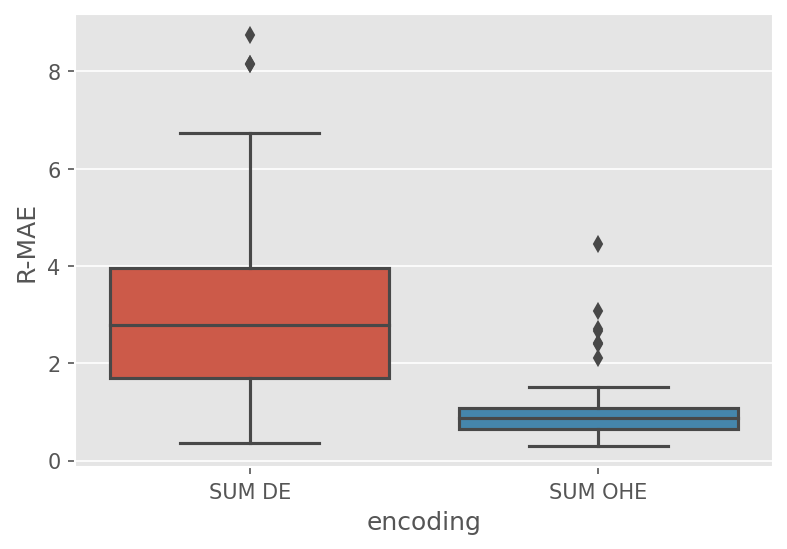

In [12]:
fig, ax = plt.subplots(dpi=150)
sns.boxplot(data=shap_dataFra, x='encoding', y='R-MAE')

<AxesSubplot:xlabel='encoding', ylabel='R-MAE'>

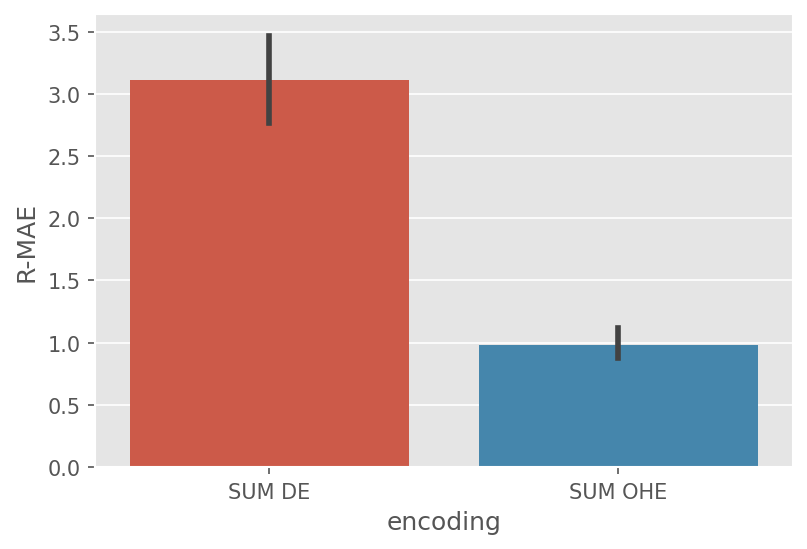

In [13]:
fig, ax = plt.subplots(dpi=150)
sns.barplot(x='encoding',y='R-MAE', data=shap_dataFra)

In [15]:
print('Mean R_MAE OHE = {} -  Mean R_MAE DE = {}'.format(np.mean(err_ohe), np.mean(err_dummies)))

Mean R_MAE OHE = 0.9835400000000001 -  Mean R_MAE DE = 3.11274
